# Continuation of an equilibrium solution

2025-11-04. Continue an ODE equilibrium solution using BifurcationKit, compare to DNS

## 0. Preliminaries

In [1]:
using LinearAlgebra, Polynomials, Plots, DelimitedFiles, BenchmarkTools, Revise
import BifurcationKit as BK

using CloudAtlas

#display("text/html", "<style>.container { width:100% !important; }</style>")

"""
    myreaddlm(filename, cc='%')

Read matrix or vector from a file, dropping comments marked with cc.
"""
function myreaddlm(filename; cc='%')
    X = readdlm(filename, comments=true, comment_char=cc)
    if size(X,2) == 1
        X = X[:,1]
    end
    X
end

sx, sy, sz, tx, tz = halfbox_symmetries()

pwd()

"/home/gibson/gitworking/CloudAtlas/notebooks"

## 1. Construct ODE model, find equilibrium solution.

This repeats some code from notebook `find-ode-eqb.ipynb`.

In [2]:
α, γ = 1.0, 2.0                     # Fourier wavenumbers α, γ = 2π/Lx, 2π/Lz
J,K,L = 1,2,3                       # Bounds on Fourier modes (J,K) and wall-normal polynomials (L)
H = [sx*sy*sz, sz*tx*tz]            # Generators of the symmetric subspace of the Nagata eqb

model = ODEModel(α, γ, J, K, L, H)  # Construct ODE model by Galerkin projection 

@show m = length(model);            # dimension of ODE model

J,K,L,m == 1,2,3,27
(2J+1)(2K+1)(2L+1) + 1 == 106
Making matrices B,A1,A2,S3...
Making quadratic operator N...
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 
m = length(model) = 27


Load initial guesses for EQ1 (lower branch) and EQ2 (upper branch) from
files. These are computed by projecting DNS solutions onto the basis, using channelflow. 

In [3]:
xguess = myreaddlm("data/xeq1projection-Re200-1-2-3-27d.asc")

R = 200
@show norm(model.f(xguess, R));

norm(model.f(xguess, R)) = 0.009524056134927641


Find the ODE representations of the lower and upper branch solutions.

In [4]:
fr = x -> model.f(x,R)    # define function  f(x) = f(x,R)  for fixed R
Dfr = x -> model.Df(x,R)  # define function Df(x) = Df(x,R) for fixed R

@time xeq1, eq1success = hookstepsolve(fr, Dfr, xguess)

@show norm(fr(xeq1))/norm(xeq1);

  1.266626 seconds (1.80 M allocations: 89.548 MiB, 2.46% gc time, 99.81% compilation time)
norm(fr(xeq1)) / norm(xeq1) = 2.6957273987400275e-10


## 2. Continuation of eqbs with BifurcationKit



Compute bifurcation diagram from xeq1 solution.

In [5]:
shear(xeq1, model)

1.646052703437098

In [6]:
myshear = x -> shear(x,model)
myshear(xeq1)

1.646052703437098

(J, K, L, m, R) = (1, 2, 3, 27, 200)


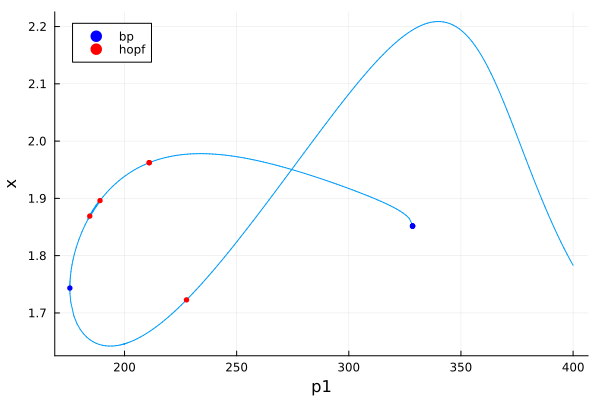

In [7]:
@show J, K, L, m, R

fp(x,p) = model.f(x,p[1])
prob1 = BK.BifurcationProblem(fp,
        xeq1,         # initial condition x0
        [Float64(R)], # set of parameters
        1;            # parameter index for continuation
        #record_from_solution = (x,p; k...) -> shear(x),
        plot_solution = (x,p; k...) -> myshear(x),
        record_from_solution = (x,p; k...) -> myshear(x),
    )

newtopts = BK.NewtonPar(1e-10, 25, false, BK.DefaultLS(), BK.DefaultEig(), false, 1.0, 0.01)
contopts = BK.ContinuationPar(p_min = 100., p_max = 400., n_inversion=20, dsmin=1e-07, dsmax=1.0, 
    max_steps = 200, newton_options = newtopts)

br1 = BK.continuation(prob1, BK.PALC(), contopts, bothside=true)

plot(br1)

Compute bifurcation diagram from xeq2 solution. For some reason BifurcationKit doesn't go around the saddle-node bifurcation. I need to learn how to tune the algorithm.

Plot the ODE bifurcation diagram along with the DNS.

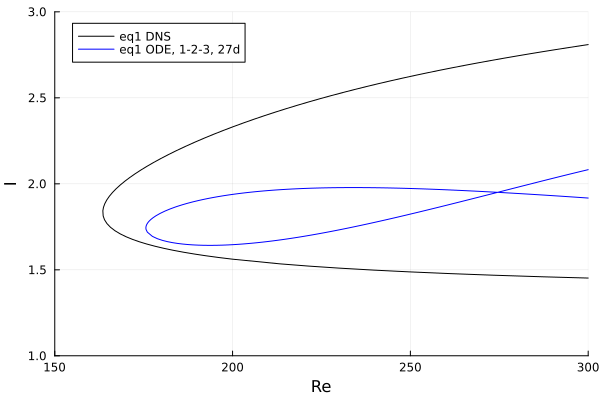

In [8]:
ReD1 = [br1.param br1.x];

eq1ReD = myreaddlm("data/eq1ReD-DNS.asc", cc='#')
plot(eq1ReD[:,1], eq1ReD[:,2], color=:black, label="eq1 DNS")
plot!(ReD1[:,1], ReD1[:,2], color=:blue, label="eq1 ODE, $J-$K-$L, $(m)d")
#plot!(ReD2[:,1], ReD2[:,2], color=:blue, label="")
plot!(xlabel="Re", ylabel="I", xlim=(150,300), ylim=(1,3))